In [1]:
!pip install -q -r requirements.txt

In [2]:
!pip uninstall -y opencv-python-headless
!pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.5.5.64
Uninstalling opencv-python-headless-4.5.5.64:
  Successfully uninstalled opencv-python-headless-4.5.5.64
  Using cached opencv_python_headless-4.1.2.30-cp37-cp37m-manylinux1_x86_64.whl (21.8 MB)


## Data Loading

In [3]:
from os.path import join
import numpy as np 
import torch
import warnings
warnings.filterwarnings('ignore')

In [4]:
DATA_ROOT="./data/"

MRI_root_dir=join(DATA_ROOT,"MRI","MRI_Label")
MRI_anno_file=join(DATA_ROOT,"MRI","annotations/MRI_Label/annotations.json")
MRI_nonLabel_root_dir=join(DATA_ROOT,"MRI","MRI_nonLabel")
MRI_nonLabel_anno_file=join(DATA_ROOT,"MRI","annotations/MRI_nonLabel/annotations.json")

In [5]:
import albumentations as A
WIDTH, HEIGHT=256,256

class DivMax(A.ImageOnlyTransform):
    def __init__(self, always_apply=True, p=1.0):
        super().__init__(always_apply, p)
    def apply(self, img, **params):
#         img=img/np.max(img)
#         img[img<0.25]=0
        img[img>5000]=0
        return img
    
transform = A.Compose([
  A.ToFloat(always_apply=True),
  DivMax(always_apply=True),
  A.Resize(WIDTH, HEIGHT),
#   A.HorizontalFlip(p=0.5),
#   A.RandomBrightnessContrast(brightness_limit=[-0.05, 0.05], p=0.2),
  A.Rotate((-30, 30), interpolation=0), 
#   A.RandomContrast(limit=0.2, p=1),   
])

test_transform = A.Compose([           
  A.ToFloat(always_apply=True),
  DivMax(always_apply=True),
  A.Resize(WIDTH, HEIGHT),
])

In [6]:
from dataloaders.ctmri_multiclass import CTMRI_MultiClassDataset,CTMRI_InferenceDataset,CTMRI_SSLDataset

ds_kwargs=dict(
    transform=transform,
    test_transform=test_transform,
    test_split=0.2
    )
MRI_ds=CTMRI_MultiClassDataset(MRI_anno_file,MRI_root_dir,**ds_kwargs)
MRI_nonLabel_ds=CTMRI_SSLDataset(MRI_nonLabel_anno_file,MRI_nonLabel_root_dir,transform=transform,test_transform=test_transform)

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [7]:
import torch.utils.data as tud
ldr_kwargs=dict(
    batch_size=8,
    shuffle=True,
    pin_memory=False,
    num_workers=2,
    drop_last=True
)
MRI_loader=tud.DataLoader(MRI_ds,**ldr_kwargs)
MRI_nonLabel_loader=tud.DataLoader(MRI_nonLabel_ds,**ldr_kwargs)

BATCHSIZE= 3
(3, 256, 256, 3) 
 (3, 256, 256)


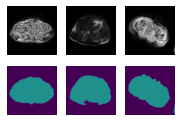

In [8]:
from utils.plotting import show_image_annot
MRI_ds.training=True
x,y=next(iter(MRI_loader))
show_image_annot(x.numpy().transpose(0,2,3,1),y.numpy(),showPics=3, vmax=2)

In [9]:
set(y.flatten().numpy())

{0, 1, 2}

In [10]:
# from models.unet import UNet
from models.resunet import ResUnet
from models.head import MetricLayer
from models.models import SegModel

backbone=ResUnet(num_classes=3,channel=3,
                filters=[64, 128, 256, 512]).cuda()
latent_dims=64
head=MetricLayer(n_in_features=latent_dims,n_out_features=3).cuda()
model_mri=SegModel(backbone,head,(WIDTH, HEIGHT)).cuda()

In [11]:
from losses.marginal import AddMarginLoss
criterion_mri = AddMarginLoss(ways=3,
                             s=10 ,m=1.4,gamma=2,alpha=0.25)
# optimizer_ct = torch.optim.SGD(model_ct.parameters(),lr=1e-3,momentum=0.9,weight_decay=0.0005)
optimizer_mri = torch.optim.Adam(model_mri.parameters(),lr=1e-3)

In [12]:
def calc_acc(pred, y):
    correct=(pred.argmax(1)==y).flatten()
    return torch.sum(correct)/len(correct)
def one_batch(i_iter,log,sample_batched,model,criterion,optimizer):
    # Prep input
    x,y=[_.cuda() for _ in sample_batched]
    pred=model(x)
    loss = criterion(pred, y)
    if model.training:
        #Update
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    with torch.no_grad():
        acc=calc_acc(pred, y).item()
        if i_iter==0:
            log['acc'] = acc
        else:
            log['acc'] = (acc+log['acc']*i_iter)/(i_iter + 1)
    # Record
    loss_rec = loss.item()
    log['loss'] = (loss_rec+log['loss']*i_iter)/(i_iter + 1)
    return pred,loss


In [13]:
from tqdm import tqdm

In [14]:
EPOCH=300
model_mri.train()
best_loss=np.inf
PAITIENCE=25
count=0
try:
    for e in range(EPOCH):
        log= {'epoch':e,'step':0,'loss': 0, 'acc': 0}
        model_mri.train()
        MRI_ds.training=True
        session=tqdm(enumerate(MRI_loader))
        for i_iter, sample_batched in session:
            pred,loss=one_batch(i_iter,log,sample_batched,model_mri,criterion_mri,optimizer_mri)
            # print loss and take snapshots
            if (i_iter + 1) % 5 == 0:
                log['step']=i_iter+1
                session.set_postfix(log)
        # validate
        if (e + 1) % 2 == 0:
            log = {'epoch':e,'step':'val','loss': 0, 'acc': 0}
            model_mri.eval()
            MRI_ds.training=False
            session=tqdm(enumerate(MRI_loader))
            with torch.no_grad():
                for i_iter,sample_batched in session:
                    pred,loss=one_batch(i_iter,log,sample_batched,model_mri,criterion_mri,optimizer_mri)
                    if (i_iter + 1) % 5 == 0:
                        session.set_postfix(log)
            # early stop        
            if log["loss"]<best_loss:
                best_loss=log["loss"]
                torch.save(model_mri.state_dict(), 'snapshots/unet_arc_mri_best.pth')
            elif count<=PAITIENCE: count+=1
            else:
                count=0
                best_loss=np.inf
                break 
            
except KeyboardInterrupt:
    print("\nHuman Interrupted")
torch.save(model_mri.state_dict(), 'snapshots/unet_arc_mri_latest.pth')

0it [00:00, ?it/s]/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:115: operator(): block: [380,0,0], thread: [0,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:115: operator(): block: [380,0,0], thread: [1,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:115: operator(): block: [380,0,0], thread: [2,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:115: operator(): block: [380,0,0], thread: [3,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:115: operator(): block: [380,0,0], thread: [4,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/pytorch/aten/src/ATen/nati

RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED